In [1]:
#I'm not sure why people makes their Fourier Positional Encoding so complicate and I'm not sure they are right. So here is my own version
#I might be wrong, but hey coding is understanding (or trying)

%%capture
!pip install einops

In [2]:
from torchvision.io import read_image
from einops import rearrange, reduce
import torch
import math
from torchvision.transforms import transforms
import matplotlib.pyplot as plt 

In [3]:
im = read_image('/content/224_224_image.jpg').to(torch.float)
print('image size:',im.size())

image size: torch.Size([3, 224, 224])


In [29]:
#Normalise the image:
mean, std = im.mean([1,2]), im.std([1,2])
normaliser = transforms.Normalize(mean, std)
normalised_image = normaliser(im)
scale = max(abs(normalised_image.max()),abs(normalised_image.min()))
normalised_image = normalised_image/scale

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


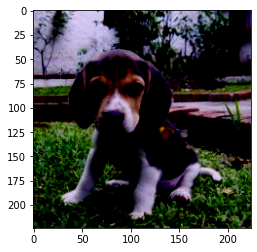

In [30]:
#Show the normalised image
plt.imshow(normalised_image.numpy().transpose(1, 2, 0))

In [31]:
# Check if the image actually get normalised between -1 and 1
print(normalised_image.max())
print(normalised_image.min())

tensor(0.9524)
tensor(-1.)


In [93]:
# Turn the image to black and white to reduce 3D dimensions to 2D dimension representing the spatial detail of the image 
collapsed_all_channels_image = reduce(normalised_image,'c h w -> h w', 'mean')
print('Collapse all channels image:',collapsed_all_channels_image.size())

Collapse all channels image: torch.Size([224, 224])


In [33]:
collapsed_all_channels_image

tensor([[ 0.7201,  0.7064,  0.7036,  ..., -0.0494,  0.0081,  0.1235],
        [ 0.6790,  0.6996,  0.7172,  ..., -0.0314,  0.0152,  0.1306],
        [ 0.6557,  0.6968,  0.7104,  ..., -0.0218,  0.0174,  0.1401],
        ...,
        [ 0.0931,  0.0850,  0.0881,  ..., -0.0969, -0.0385, -0.0755],
        [-0.1820, -0.1515, -0.1323,  ..., -0.0379,  0.1669,  0.1669],
        [-0.4429, -0.2913, -0.1924,  ..., -0.0384,  0.1008,  0.0871]])

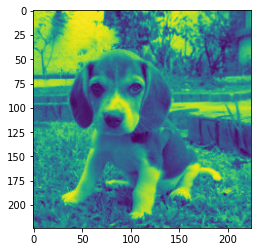

In [34]:
plt.imshow(collapsed_all_channels_image.numpy().transpose(0,1))

In [35]:
#Check new image dimension
collapsed_all_channels_image.size()

torch.Size([224, 224])

In [38]:
#create a log splace tensor between 1 and pi/2
fk_sin = torch.logspace(start=1, end=0.5*math.pi, steps=7, base=2)
fk_cos = torch.logspace(start=1, end=0.5*math.pi, steps=7, base=2)
pe = torch.zeros(224,224,7*2+1)

In [40]:
# Create a fourier positional encoding
for j in range(224):
  for i in range(224):
    x = collapsed_all_channels_image[j][i]
    sin = torch.sin(math.pi*x*fk_sin)
    cos = torch.cos(math.pi*x*fk_cos)
    fk = torch.cat((sin,cos))
    fk_ = fk.tolist()
    fk_.append(x.item())
    fk = torch.tensor(fk_)
    pe[j][i]=fk

In [41]:
pe.size()

torch.Size([224, 224, 15])

In [42]:
#Flatten the pe array:
pe = rearrange(pe,'h w f -> (h w) f')

In [43]:
pe

tensor([[-0.9824, -0.9927, -0.9005,  ...,  1.0000,  0.9059,  0.7201],
        [-0.9627, -0.9996, -0.9387,  ...,  0.9938,  0.9525,  0.7064],
        [-0.9577, -1.0000, -0.9456,  ...,  0.9908,  0.9602,  0.7036],
        ...,
        [-0.2387, -0.2546, -0.2715,  ...,  0.9444,  0.9366, -0.0384],
        [ 0.5917,  0.6260,  0.6612,  ...,  0.6367,  0.5893,  0.1008],
        [ 0.5203,  0.5518,  0.5846,  ...,  0.7242,  0.6874,  0.0871]])

In [44]:
pe.size()

torch.Size([50176, 15])

In [113]:
#Explaination:
# Along this dimension, there are 50176 inputs, which is equivalent to the flatten image array of 224 x 224
# Within each input, there are 15 values, these 15 values corresponds to 2K + 1. Where K is the number of bands. In this example, a value of 7 was used. The reason you times K by 2 is because
#you need to calculate the cos and sin value for each band frequency. You add 1 to the end because you need to concat the normalised input with the 14 fourier values (7*2+1 = 15)
print('Number of positional encoding values for each input:',pe.size(1))

Number of positional encoding values for each input: 15


In [83]:
#Now lets see if I can feed this positional encoding into a cross attention layer to create a Perceiver model

to_key = torch.nn.Linear(15,512)
to_v = torch.nn.Linear(15,512)

In [84]:
k = to_key(pe)
v = to_v(pe)

In [85]:
k.size()

torch.Size([50176, 512])

In [86]:
# Lets make a fake q created from a latent array
q = torch.rand(100,512)

In [87]:
I = torch.matmul(q,k.transpose(1,0))

In [88]:
I.size()

torch.Size([100, 50176])

In [89]:
attention = torch.matmul(I/512**0.5,v)

In [90]:
attention.size()

torch.Size([100, 512])

In [91]:
#The attention has the size of 100,512; which is a significant bottleneck reduction

In [92]:
attention

tensor([[ 6.1122e+03,  1.1272e+03,  8.0486e+02,  ...,  1.7737e+03,
         -6.9754e+03, -6.8565e+02],
        [ 4.2422e+03,  1.5609e+03,  7.1089e+02,  ..., -2.3765e+01,
         -4.5993e+03, -1.1109e+02],
        [ 6.7876e+03,  1.8105e+03,  2.0410e+03,  ...,  2.2781e+03,
         -9.7237e+03, -8.2564e+00],
        ...,
        [ 3.2173e+03, -9.6129e+02, -6.7591e+02,  ...,  2.2785e+03,
         -3.3900e+03, -2.3531e+03],
        [ 4.2476e+03,  3.7474e+02, -6.8156e+01,  ...,  7.5019e+02,
         -3.5073e+03, -1.1348e+03],
        [ 5.6610e+03,  1.8099e+03,  1.3791e+03,  ...,  1.4933e+03,
         -7.1279e+03,  2.9682e+02]], grad_fn=<MmBackward>)